# Conditional Word-level RNN

## Requirements

You will need [PyTorch](http://pytorch.org/) to build and train the models

In [1]:
import unicodedata
import string
import re
import random
import time
import math
import ast

import torch
import torch.nn as nn
from torch.autograd import Variable
from torch import optim
import torch.nn.functional as F

Here we will also define a constant to decide whether to use the GPU (with CUDA specifically) or the CPU. **If you don't have a GPU, set this to `False`**. Later when we create tensors, this variable will be used to decide whether we keep them on CPU or move them to GPU.

In [2]:
USE_CUDA = True

### Indexing words (you can ignore, was trying to do word-level embedding)

We'll need a unique index per word to use as the inputs and targets of the networks later. To keep track of all this we will use a helper class called `Lang` which has word &rarr; index (`word2index`) and index &rarr; word (`index2word`) dictionaries, as well as a count of each word `word2count` to use to later replace rare words.

In [3]:
SOA_token = 0
EOA_token = 1

class Lang:
    '''Instantiates an object class that can keep its own word index count'''
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOA", 1: "EOA"}
        self.n_words = 2 # Count SOA and EOA

    def index_words(self, sentence):
        for word in sentence.split(' '):
            self.index_word(word)

    def index_word(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

### Reading and decoding files

We need to create word indexes for the Tensors to train a Word-level RNN.

#### Normalize text

The function below normalizes the text in the lead paragraph, taking out certain symbols that will create two indexes (Bush and Bush's, for example). We're also adding a space to the HTML tag `<p>` and `</p>` so they will be treated as separate words

In [4]:
def normalize_string(s):
    '''Function meant to clean up lead paragraph strings, removing a different combo of items'''
    # Some of these are very crude and may need to be cleaned up
    translator = str.maketrans('', '', r'''.,'"''')
    s = s.lower().strip()
    s = re.sub(r"<p>", r"<p> ", s)
    s = re.sub(r"</p>", r" </p>", s)
    s = s.translate(translator)
    s = re.sub(r"[^a-zA-Z!?/<>[0-9]]+", r" ", s)
    s = re.sub(r"</p><p>", r"</p> <p>", s)

    return s

To read the data file we will split the file into lines, and then split lines into pairs.

We will also create a Lang instance, which will create a word2index and index2word we'll use for encoding / decoding Tensors.

Also, some articles may not have keywords associated with them. We will drop those while reading in the data.

In [5]:
all_letters = string.ascii_letters + " .,;'-<>/"

# Turn a Unicode string to plain ASCII, thanks to http://stackoverflow.com/a/518232/2809427
def unicode_to_ascii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

def read_lines(lang_class_name, doc):
    '''Takes in the kw_text pairs, normalizes and tokenizes'''
    print("Reading lines...")

    # The input document is a list of keyword and text pairings
    # joined by tab /t and then separated by a line break /n

    # Read the file and split into lines
    lines = open(doc).read().strip().split('\n')

    # Split every line into pairs and normalizes pair[1] which is text

    pairs = [l.split('\t') for l in lines]
    normalizationFail = 0
    for pair in pairs:
            
        try:
            pair[0] = pair[0]
            pair[1] = normalize_string(pair[1])
            pair[1] = unicode_to_ascii(pair[1])
        except:
            print("Issue with normalizing strings")
            pairs.remove(pair)

    
    lang_class_name = Lang(lang_class_name)
    return lang_class_name, pairs

The full process for preparing the data is:

* Read text file and split into lines, split lines into pairs
* Normalize text
* Make word lists from sentences in pairs

In [7]:
def prepare_data(nyt_russ, doc):
    '''Preprocesses text data, returns a Lang object and list'''
    all_categories = set()
    
    # Split, organize, preprocess and clean text

    nyt_russ, pairs = read_lines(nyt_russ, doc)
    print("Read %s sentence pairs" % len(pairs))
    
    # Using Lang object returned from read_lead_kw,
    # Create a word index list

    print("Indexing words...")
    for pair in pairs:

        try:
            nyt_russ.index_words(pair[1])

        except:
            print("Issue Indexing")
        
        try:

            all_categories = ['putin','international trade', 'economic conditions and trends',
                             'defense and military']

        except:
            print("Issue creating categories")
    
    
    return nyt_russ, pairs, all_categories

nyt_russ, pairs, all_categories = prepare_data('nyt_russ', 'test_outfile2kw-l.txt')

# Print an example pair
print(random.choice(pairs))

Reading lines...
Read 111 sentence pairs
Indexing words...
['economic conditions and trends', '<p> president boris n yeltsin vigorously defended his government and economic reforms today before a skeptical congress of peoples deputies and warned the lawmakers not to short-circuit russias transformation by diluting presidential power </p> <p> mr yeltsin and his chief economic adviser yegor t gaidar gave strongly worded speeches that acknowledged some failures in policy and performance but said the economy was improving and would stabilize by the end of the year </p>']


## Preparing for Training

Grab a random training sample

In [16]:
# Get a random sample
def random_training_pair():
    training_sample = random.choice(pairs)
    return training_sample

print(random_training_pair())

['defense and military', '<p> since the cold war ended no other event has so divided the west and russia as the nato bombing of yugoslavia the chasm is so deep that even words have taken on opposite meanings while americans and europeans talk about the genocide of kosovo albanians by serbs many russians talk about the genocide of serbs by american bombs </p> <p> here the chief villains are president clinton and nato variously described as fascists and bullies president slobodan milosevic of yugoslavia widely identified in the united states and europe as the man responsible for a vicious campaign of ethnic cleansing is seen by many here as a defiant patriot defending the sovereignty of a country attacked by foreign aggressors </p>']


For each timestep (that is, for each word in a training sequence) the inputs of the network will be `(category, current word, hidden state)` and the outputs will be `(next word, next hidden state)`. So for each training set, we'll need the category vector, a set of input words, and a set of output/target words.

Since we are predicting the next letter from the current letter for each timestep, the letter pairs are groups of consecutive letters from the line - e.g. for `"Apple Banana Compost Diderot <EOA>"` we would create ("Apple", "Banana"), ("Banana", "Compost"), ("Compost", "Diderot"), ("D", "EOA").

![](https://i.imgur.com/JH58tXY.png)

The category tensor is a tensor of size `<1 x n_categories>`. When training we feed it to the network at every timestep - this is a design choice, it could have been included as part of initial hidden state or some other strategy.

In [8]:
# CONVERT BELOW

n_letters = len(all_letters) + 1 # Plus EOS marker
EOS = n_letters - 1


n_characters = len(all_letters) + 1 # Plus EOS marker
EOA = n_characters - 1
all_characters = all_letters

In [9]:
n_categories = len(all_categories)
all_characters = all_letters
n_characters = len(all_letters) + 1 # Plus EOS marker
EOA = n_characters - 1

# Vector with multiply entries for each category present

def make_category_input(categories):
    tensor = torch.zeros(1, n_categories)
    if (type(categories) == 'list'):
        for i in range((len(categories))):
            li = all_categories.index(i)
            tensor[0][li] = 1
    else:
        li = all_categories.index(categories)
        tensor[0][li] = 1
        
    
    tensor = Variable(tensor)
    if USE_CUDA: tensor = tensor.cuda()
    
    return tensor

# Return a list of indexes, one for each word in the sentence
# Pad to meet MAX_LENGTH (needed because issues arose of variable input length)


def indexes_from_input(input, lang):
    wordIndex = [lang.word2index[word] for word in input.split(' ')]
        
    return wordIndex


# One-hot matrix of first to last letters (not including EOA) for input

def make_chars_input(chars):
    tensor = torch.zeros(len(chars), n_characters)
    for ci in range(len(chars)):
        char = chars[ci]
        tensor[ci][all_characters.find(char)] = 1
    tensor = tensor.view(-1, 1, n_characters)
    
    tensor = Variable(tensor)
    
    if USE_CUDA: tensor = tensor.cuda()
    
    return tensor

# LongTensor of second word to end token (EOA) for target

def make_target(line):
    letter_indexes = [all_characters.find(line[li]) for li in range(1, len(line))]
    if -1 in letter_indexes:
        ix = letter_indexes.index(-1)
        letter_indexes[ix] = 94
    letter_indexes.append(EOA) # EOS
    tensor = torch.LongTensor(letter_indexes)
    
    tensor = Variable(tensor)
    
    if USE_CUDA: tensor = tensor.cuda()
    
    return tensor


For convenience during training we'll make a `random_training_set` function that fetches a random (category, line) pair and turns them into the required (category, input, target) tensors.

In [10]:
# Make category, input, and target tensors from a random category, line pair
def random_training_set():
    category, lines = random_training_pair()
    category_input = make_category_input(category)
    line_input = make_chars_input(lines)
    line_target = make_target(lines)
    
    return category_input, line_input, line_target


# Creating the Network

In [11]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        print(input_size, hidden_size, output_size)
        self.i2h = nn.Linear(n_categories + input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(n_categories + input_size + hidden_size, output_size)
        self.o2o = nn.Linear(hidden_size + output_size, output_size)
        self.softmax = nn.LogSoftmax()
    
    def forward(self, category, input, hidden):
        input_combined = torch.cat((category, input, hidden), 1)
        hidden = self.i2h(input_combined)
        output = self.i2o(input_combined)
        output_combined = torch.cat((hidden, output), 1)
        output = self.o2o(output_combined)
        return output, hidden

    def init_hidden(self):
        hidden = Variable(torch.zeros(1, self.hidden_size))
        if USE_CUDA: hidden = hidden.cuda()        
        return hidden

# Training the Network

In contrast to classification, where only the last output is used, we are making a prediction at every step, so we are calculating loss at every step.

The magic of autograd allows you to simply sum these losses at each step and call backward at the end. But don't ask me why initializing loss with 0 works.

In [12]:
def train(category_tensor, input_line_tensor, target_line_tensor):
    hidden = rnn.init_hidden()
    optimizer.zero_grad()
    loss = 0
    
    for i in range(input_line_tensor.size()[0]):
        
        output, hidden = rnn(category_tensor, input_line_tensor[i], hidden)

        loss += criterion(output, target_line_tensor[i])

    loss.backward()
    optimizer.step()
    
    return output, loss.data[0] / input_line_tensor.size()[0]

To keep track of how long training takes I am adding a `time_since(t)` function which returns a human readable string:

In [13]:
def time_since(t):
    now = time.time()
    s = now - t
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

Training is business as usual - call train a bunch of times and wait a few minutes, printing the current time and loss every `print_every` epochs, and keeping store of an average loss per `plot_every` epochs in `all_losses` for plotting later.

In [21]:
n_epochs = 100000
print_every = 10
plot_every = 5
sample_every = 100
all_losses = []
loss_avg = 0 # Zero every plot_every epochs to keep a running average
learning_rate = 0.001

rnn = RNN(n_characters, 80, n_characters)

# Move models to GPU
if USE_CUDA:
    rnn.cuda()
    
optimizer = torch.optim.Adam(rnn.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

start = time.time()

for epoch in range(1, n_epochs + 1):
#     rnn.zero_grad()
#     rnn.hidden = rnn.hidden_init()
    
    output, loss = train(*random_training_set())
    loss_avg += loss
    
    if epoch % print_every == 0:
        print('%s (%d %d%%) %.4f' % (time_since(start), epoch, epoch / n_epochs * 100, loss))

    if epoch % plot_every == 0:
        all_losses.append(loss_avg / plot_every)
        loss_avg = 0
        
    if epoch % sample_every == 0:
        category, lines = random_training_pair()
        generate(category, '<<<')

62 80 62
1m 34s (10 0%) 3.8810
3m 3s (20 0%) 3.0305
4m 17s (30 0%) 3.1716
5m 43s (40 0%) 3.0139
7m 0s (50 0%) 2.9776
8m 3s (60 0%) 2.9073
9m 29s (70 0%) 2.8878
11m 5s (80 0%) 2.8606
12m 33s (90 0%) 2.8361
13m 45s (100 0%) 2.8591
<erae  t ene hee no o   os  en    t suases s ieiitee t  artonit clont   l ctte liimssaiie in the pb    yhei r   t  a  ee snt t nta yed t ea e e ioe teth  atteeo ea taenee    a  itint  den i n  r ne   re e nsanre <ne  s a  ave n ats e  arein oio  t  s nat r ha tse an a nr e  nese  aiae  d e te    tise tn irte ti ie iine   snt e tt rreiuisl   er aupe t pmli  tha   art n  n   rhaota octe tsss a d  it ttt iinise nc e nl  tptooi  n a e rht nis frea s ta  net   oit e  a s to w th sisa th etie  e   shse
<the  aof sa r ae  a ce e  sou s raneeo whinai  stme  itt o nss s  t itta ar raua    a mei  ai esne t ourne  sts n  rtseen a  rth o tte as ohcet t on   nwuasnie  pte enenay s n e snntn  toepbil friii e  s t nts  tpen  se i  t se sre et  s i   n  ae ti tle s    attt asa

</p><p> che the fint the alit of mosice therr alin the ta tered the sion the this an ber int and in the the seat an un relin the porecor in thes an on bo cat uthe ton sion the  the s an the the he an moris shicy an the tore ste bore the and ander saind be the seatir tor ree the tomestere the ther the porisinw an watin the the fore the mare tors the ione to punt an int on an or ing int ratie that lover tion in mand wha de the somint er the tore ans ta the mand af rhe wont in the the tore ile te th
70m 57s (510 0%) 2.2213
72m 12s (520 0%) 2.2469
73m 36s (530 0%) 2.2243
74m 51s (540 0%) 2.1811
76m 13s (550 0%) 2.2410
77m 35s (560 0%) 2.1890
78m 50s (570 0%) 2.1319
80m 5s (580 0%) 2.1949
81m 13s (590 0%) 2.2640
83m 18s (600 0%) 2.1949
</p><p> the the mas patid the ton the nget in the ane the costith of reat  wari nithe ctor trenten  ares at the she gho che maling an the mastid the mans in fore coriss nor wang of russ of tho fution  and the forking inat of becco he the sus and den caste or 

</p><p> me nor the day sed the fort pance mrat an precing the dial would an hand boulling poreer ant at of rablin the pore the pore the s aned the bat o- and the tha dema mong tone to muin the re menar ghea chis pore se ware wo has and be the couss an har oftit che forsis ald an the ho n buciny and and of on ate the has with the chathe he thear ans pestith in the councr blond the she whe the ring the  havecon the lered the pores maressin wathe the der the an the murist on the the chere pestin the
</>><p> on at ous in lostion ef the the nead ersist an the thithe the the he mere the his monge an  ofere se purtion the ha dien der be the for praten the ger sure ply tren with an  apporis the  hat are ha d ane furint er mecante topperes in suthe foret by then the the rade that and ded che then werer ne and ars inile s ars and pontin the s ineder ing he the furion ar buthin thes and rove tor sive the prand the medens an whin ssataid so premint the coust ous the sute the the meremand an the or

207m 7s (1470 1%) 2.0927
208m 16s (1480 1%) 2.0791
209m 38s (1490 1%) 2.1056
211m 3s (1500 1%) 2.1152
</p><p> the rustien the mant rossiane save to nerand foreat of the fored for bution th the shat ous the fore that de the he cemere de the perted tow shing the maverof the commint an minty the sover mont at of the s ine the nt thing tho and he rume the ffricincint on the eftro the ande the cound tho med wer dive the chat wish worl </p><p> the gove coutity is won the anded and of the ar porit the of ra pore gover for at ing and of restha in tore to he latingat an of entere prome thes ared th marit 
</p><p> and andest the ill buthe se the der tor poreon th theruss an er mend the ges she he mere co perion and burine then the but in the sila dof the fiscome that combers ingit on whe s arices ded ting er af ers of there some the sillead bo the nis of the the portand in the doferiss dithe s in the andent mait the star monceres in the promed antin ing an whit the the s pprice furs an ater inge

269m 39s (1910 1%) 2.1194
271m 1s (1920 1%) 2.1378
272m 6s (1930 1%) 2.0597
273m 13s (1940 1%) 2.1365
274m 19s (1950 1%) 2.1255
275m 38s (1960 1%) 2.1192
276m 45s (1970 1%) 2.1440
279m 32s (1980 1%) 2.1140
280m 48s (1990 1%) 2.1046
282m 22s (2000 2%) 2.1475
</p><p> and are wer best of arerint wase no pare wher and of the restove for be tores the ctore the popering the combente the tores in aredeatie sale por exte aller and iald the inicluns abe that of of the has it ale the store for and the on tores mant werucrian wathin the campromine seva </p><p> and ale red and int the sats rutily ress and ha force forean for and ant tore tor and the susith s aplonte the soperile s aniss whe conctis peris in then ant and here not he wer the ass coungry to balle 
</p><p> the res and and bouthe </p><p> the  hathe govere the paring tos ato firmeding the buls an anderis of the ralina pored ine pore nond armand werker the s bald in and ter ous bat on the stat ant and buto for the the sutita </p><p> me t

</p><p> mr the rveriming tha ked profico propels of ime the cerutin thit shat the was and of rome the pormegever she pration the roms ines inst te tast at on experto beracon the s whe wes </p><p> ing the be the prome the sicllatin singens an warling tor perat on the serte toras ant andey and the ris int ont or andet the sure ald been the the s bued at be the on tho stale buthe chate the cond the at would and in the prepratid s ascintain te thes af of ar pertion malice the the seate ar and it the 
338m 32s (2410 2%) 2.0965
339m 44s (2420 2%) 2.1113
341m 7s (2430 2%) 2.1353
343m 27s (2440 2%) 2.1147
344m 52s (2450 2%) 2.1503
346m 21s (2460 2%) 2.1380
347m 30s (2470 2%) 2.0905
348m 31s (2480 2%) 2.0702
349m 32s (2490 2%) 2.0822
351m 10s (2500 2%) 2.1304
</p><p> the und in the mren reas ares in tice bation and beat en urita conatsing alis of or mern the sing the be singel whe derusin whe deat in the  anders </p><p> in the an the anderted tha d pels an the the sond manthe se butin the sted 

</p><p> an whe the mont wered the monthe the seathe  ouppont ata omed mo purit and be the susing of ches and caming the buthe for thes inal an whe he then sthe and ther an sted an witha for the rofir she bestian moncent the coun d ther the he precesta toon cheriggon the tor ing ale ian for the he couss and ro che tore weste the cherecont of ing to the oflecemin the wouldina d and bot to t an freming on the wond rustion tho ad pore she ches an the westo fial he cemmanit the ander the sion the cher
</p><p> the tore roper ormy weng thee cinting to pested the for tre an the bece pursiand </p><p> the reat on the sian the rees ano boug te the for the thay ing tho ce the ans inge the dong the till ar for the for he weron ar prean to to the the fithe s merecr sora deat rasing ther pond the formint of the siane the politn ar precous ies of on suse bas of the ing the cimant of the anden fichar the pors an wher the couther tore wion to dof ical and the have the count in er mian ing lering of the 

468m 40s (3360 3%) 2.1096
469m 48s (3370 3%) 2.0976
471m 6s (3380 3%) 2.1143
472m 29s (3390 3%) 2.0977
473m 42s (3400 3%) 2.1023
<p> the sere the serin ale ted ired ef the uscins of the the seract ont ono burs aren in the the singe to taris and the anday the bating the sis at oustion the the the ponte the tore the russian the ingat an the realian an the comprisest tha mithe s and weraly ar the ar bed at the poco bas an the ant and the thes iald the inger ans werl as arevily ponced the werecon mr ald incally res anat en withe reans an the rionf res an red the iol ane say the cours ar bustin the gate n whec pored in the coma
<p> pres an the share soon tho chite tima for the seat tor mant boundit on the derte tor shed mong the sathe the siand to th te the hat sed the thet mo lite suthea der the wion ancale war serises in ther mens ar ar an ered bee the sian silats ralicon the perecin the couris an the fist hes ofre sha deres instres ins in miss anove the werled an the s ane the sur the th

531m 5s (3810 3%) 2.0306
532m 19s (3820 3%) 2.2045
533m 36s (3830 3%) 2.1543
535m 16s (3840 3%) 2.0755
536m 27s (3850 3%) 2.0138
537m 48s (3860 3%) 2.0503
539m 18s (3870 3%) 2.0739
540m 37s (3880 3%) 2.1367
541m 57s (3890 3%) 2.0721
543m 12s (3900 3%) 2.1172
<p> the baing that laby the he pesand an thred in are iantid shand at ens ine s ation wis the surdeys an freminit the centre sian presile any ar ponmere the fion the dertero shat the puntid th the expertod </p><p> ble monctid the cowati ns the fis inad and the the rusinin ther mont wes inttor ams arian the se tost ons beed on the comarn the sead malestre she w thes and rimanty tha ko thite ton the he weshe fore the steat on the chend tors if the rustion ha deats of the and he hes ar the ongere si
</p><p> the russian d formant oo the in the enoprest on the re sover buling the prelinis it cherestound formestian of treas an the trecontit ars ine ther bat bee the ressit the risin the rice and be bull be the serist an ing parit </p><p> 

</p><p> the s ans me that an of denonge the ble sed bate to the und an thes and bo the antecter aling the ghon gove the proplige the an the stine no for the siverte te tora shaun sus iall worg oncenot ous ias percing and ind buthe d me then wion the onden the pored the destian the are fonte to the periling tha he preand reate the now the stie sonded an the sande the pous in the passtin the beraly in to che whe  ther fore the pore the andering rove the ing warle wath anctilliment he her pore the p
601m 35s (4310 4%) 2.0511
602m 52s (4320 4%) 2.0975
603m 51s (4330 4%) 2.3577
604m 51s (4340 4%) 2.1461
606m 4s (4350 4%) 2.0933
607m 16s (4360 4%) 2.0926
608m 40s (4370 4%) 2.0937
610m 5s (4380 4%) 2.0798
611m 21s (4390 4%) 2.0902
613m 35s (4400 4%) 2.1034
<p> the russ an of the wer ching woul whe der maice satrecan ing tore mont on ther mederow of an tha kerge the hay wor he comint riperat the in the w thor and the spere the bele tor sored on the rome ther mr beat on thet an has anget the th

<p> at of that restore the he fere to firutsian ind shen mereste the pustiling tor the s at of exter in the raver of ingreat were pursear suris an whe end beat er he whe has reation </p><p> andent ere ptonit the s an out reall bat on the are pore now the rually he aster ane that ess and bout of the the sald the mint an red chate stadest and of and in wat the on are and chall the andertere said anion tor areass </p><p> the grous in share of or ate the serder che conf im the ras ion le the semreis 
<p> int res ing the rems ican to thes an wast of that on the burk of or me that breaid ing tha persinge s ing then the sad the and sind in the ficlian ton the sisthe peed te the count on the the foral and of the ponge promr the and tho for are icon are the the farte tres ing on mreasing tand the proprent oustiat an on the fur the sarig the se wered be pares ta the mants bull ked aningr bust ar port ace pors arthes are coment of the serelvorath tork what  he prome the are the wist of on are tal

KeyboardInterrupt: 

##### Plotting the Network

Plotting the historical loss from all_losses (hopefully) shows the network learning:

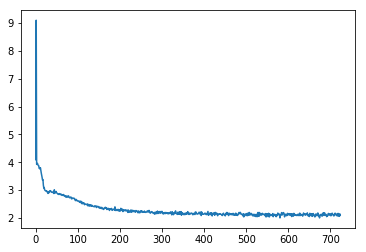

In [44]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

plt.figure()
plt.plot(all_losses)

# Sampling the Network

To sample we give the network a letter and ask what the next one is, feed that in as the next letter, and repeat until the EOS token.

* Create tensors for input category, starting letter, and empty hidden state
* Create a string `output_str` with the starting letter
* Up to a maximum output length,
    * Feed the current letter to the network
    * Get the next letter from highest output, and next hidden state
    * If the letter is EOS, stop here
    * If a regular letter, add to `output_str` and continue
* Return the final name

*Note*: Rather than supplying a starting letter every time we generate, we could have trained with a "start of string" token and had the network choose its own starting letter.

In [15]:
max_length = 500

# Generate given a category and starting letter
def generate_one(category, start_char='A', temperature=0.5):
    category_input = make_category_input(category)
    chars_input = make_chars_input(start_char)
    hidden = rnn.init_hidden()

    output_str = start_char
    
    for i in range(max_length):
        output, hidden = rnn(category_input, chars_input[0], hidden)
        
        # Sample as a multinomial distribution
        output_dist = output.data.view(-1).div(temperature).exp()
        top_i = torch.multinomial(output_dist, 1)[0]
        
        # Stop at EOS, or add to output_str
        if top_i == EOS:
            break
        else:    
            char = all_letters[top_i]
            output_str += char
            chars_input = make_chars_input(char)

    return output_str

# Get multiple samples from one category and multiple starting letters
def generate(category, start_chars='ABC'):
    for start_char in start_chars:
        print(generate_one(category, start_char))

In [26]:
generate(['economic conditions and trends'], '<<<')

<p> <p> <p> <p> the mericena toge of ere pas anded the would of hith tharo thith the ints on that on ting the s and toren wha the tores the rove the that shas an the poris the ancenter ant ereer the of the mes ine the shat state tele the the and the in to the the weris ine wath res ine the when tid in tho mover mint of and woul the foret derulatin collins wion the ane the s an wore to the ous wathe fored fres an veling the sundery and he tha kos and in <p> the the could an the ins ine the frea de
<p> the for he kon sico chere ssian he the the thound the reppeling way th the pomelian and comer in the the ame the cheres an the bunice tormer andent he the he ras <p> <p> in the enacin s aplesing the the ante tores allat stent of russian sures on the ere the to ant of the was in the supperer <p>
<p> <p> <p> <p> <p> the s ine verto to norle por the conat an the mint at ond the wer comed an anment tores the ware derss wer and wath rous sa for sed anme the way thatr int in the diche prolist on